In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
import random
import scipy.stats as stats
import scipy
from sklearn.model_selection import train_test_split, cross_val_score
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, accuracy_score
import time


In [ ]:
def generateNormalVariables(n, p):

    X = {} # initialize dictionary to hold values

    for j in range(p):
        #np.random.seed(seed = j)   #seed for distribution
        #random.seed(j)   #seed for random number generator
        X[j] = np.random.normal(0, 1/np.sqrt(n), n) # NOTE: ADDED 1/SQRT(N) SCALING 3/31
    return X

def generateX(n,p):
    
    # Initialize dataframe with an intercept column
    #intercept = np.repeat(1,n) # Create n 1's for intercept column
    #X = pd.DataFrame(intercept.reshape(n,1))
    # COMMENTED OUT INTERCEPT FOR TIME BEING. CAUSING ISSUES WITH SIGNAL STRENGTH SCALING
    X = pd.DataFrame()
    
    # Generate data
    if p != 0:
        Xnorm = generateNormalVariables(n, p)
        Xnorm = pd.DataFrame.from_dict(Xnorm)
        X = pd.concat([X, Xnorm],ignore_index=True,axis=1)
    
    return X

def generateRandomBeta(q, mu, stdev):
    beta = {}
    for j in range(q):
        #random.seed(j)#seed for random number generator
        beta[j] = np.random.normal(mu,stdev)
        #beta[j] = np.random.poisson(stdev)-3 # Checking to see what happens when betas come from noncentral poisson
        #beta[j] = np.random.uniform(mu,stdev)
    
    beta = pd.DataFrame(list(beta.items()))
    beta = beta.drop([0],axis=1)
    
    return beta

def sigmoid(z):
    return 1/(1+np.exp(-z))

def generateResponseVariable(X, beta, dist):
    
    beta = np.squeeze(beta)
    
    if dist == 'bernoulli':
        meanValues = sigmoid(X.dot(beta)) 
    elif dist == 'poisson':
        meanValues = np.exp(X.dot(beta))
    elif dist == 'exponential':
        meanValues = 1/(X.dot(beta))
    else:
        print('please spell check distribution name, all lowercase: bernoulli, poisson or exponential')
        
    y = []
    
    #np.random.seed(123)
    for eachMean in np.squeeze(meanValues.values):
        if dist == 'bernoulli':
            randomPrediction = np.random.binomial(1,eachMean)
        elif dist == 'poisson':
            randomPrediction = np.random.poisson(eachMean)
        elif dist == 'exponential':
            randomPrediction = np.random.exponential(eachMean)
        y.append(randomPrediction)
        #print(randomPrediction, eachMean)
    
    return meanValues, y

def generateData(dist, n, p, mu, stdev, signal_strength):
    
    # Generate Data
    X = generateX(n=n, p=p)

    # Generate Betas
    q = X.shape[1]
    beta = generateRandomBeta(q=q, mu=mu, stdev=stdev)
    beta_norm_squared = beta.T.dot(beta).values[0,0]
    beta_scaled = beta * np.sqrt((n * signal_strength) / beta_norm_squared)

    # Generate Response Variable (and associated means - what goes into the link fn)
    means, y = generateResponseVariable(X=X, beta=beta_scaled, dist=dist) ### dist means pass distribution name as string
    
    # Make sure we return numpy arrays (easier to work with later and all names are useless here anyway)
    beta_scaled = np.squeeze(np.array(beta_scaled))
    X = np.array(X)
    y = np.array(y)    
    
    return X, beta_scaled, y, means




def generate_sample(n, mu=10, covariates=None):
    # number of observations
    # n=200

    # number of (Gaussian) covariates
    # p=200# int(n/5)
    if not covariates:
        p = int(n / 5)
    else: 
        p = covariates

    # signal strength
    # signal_strength = 5
    signal_strength = 10

    # Parameters for Distribution to draw Betas from. Betas ~ N(mu, stdev^2)
    # EF: mu = mu
    stdev = 1.0

    # Generate the data
    # - X is an (n,p+1) dimensional array with the n rows corresponding to observations and the p+1 columns
    #   corresponding to the covariates + a column of 1's (for the intercept term)
    # - Beta is the (p+1,) dimensional array of 'True' regression coefficients
    # - y is the (n,) dimensional array of response values for the observations
    # - means is the (n,) dimensional array of predicted values (probabilities in case of logistic)
    # *THOUGHT: Perhaps we could use another term instead of means to avoid confusion with the systematic component?
    # * perhaps y_hat, preds, etc?
    X, Beta, y, means = generateData(dist = 'bernoulli', n = n, p = p, mu = mu, stdev = stdev, 
                                    signal_strength = signal_strength) 


    df = pd.DataFrame(X)
    y = np.array(y)
    # y = np.where(y>0,1,-1)# Changed label 0 to -1, For convenience, we choose the label as {-1,1} instead of {0,1}
    df['y'] = pd.Series(y)
    return df



def plot_betas(betas):
    plt.scatter(list(range(len(betas))), betas)
    plt.show()


In [ ]:
np.random.seed(52)
sample_size = 1000
new_seeds = np.random.randint(10000000, size=500)
data_points = []
p_vals = []

start_time = time.time()
for count, seed in enumerate(new_seeds):
    loop_start_time = time.time()

    np.random.seed(seed)
    ## ********* Below looks Chi-Squared *********
    samp2 = generate_sample(1000, covariates=250)
    # samp2 = generate_sample(50, covariates=2)
    ##
    # Try to dynamically create bins
    # Try to dynamically create bins for kl-divergence
    # get more samples per bin

    
    # samp2 = generate_sample(sample_size, covariates=25)
    
    # samp2 = sm.add_constant(samp2)
    # print(samp2.head())

    # X2_train, X2_test, y2_train, y2_test = train_test_split(samp2.loc[:,~samp2.columns.isin(['y'])], samp2.y.to_list(), test_size=0.25)
    # print(samp2.loc[:,~samp2.columns.isin(['y',3, 4, 5, 6, 7, 8])])

    log_reg1 = sm.Logit(samp2.y.to_list(), samp2.loc[:,~samp2.columns.isin(['y', 1])]).fit(disp=0)
    log_reg2 = sm.Logit(samp2.y.to_list(), samp2.loc[:,~samp2.columns.isin(['y'])]).fit(disp=0)

    lrt = -2 * (log_reg1.llf - log_reg2.llf)
    data_points.append(lrt)
    p_vals.append(scipy.stats.chi2.sf(lrt, 1))

    if count % 10 == 0:
        end_time = time.time()
        print(f'Count: {count} Since Start: {end_time - start_time} Current Loop: {end_time - loop_start_time}')


Count: 0 Since Start: 0.5868117809295654 Current Loop: 0.5864181518554688
Count: 10 Since Start: 5.776796340942383 Current Loop: 0.5171658992767334
Count: 20 Since Start: 10.844865083694458 Current Loop: 0.5041768550872803
Count: 30 Since Start: 16.185197114944458 Current Loop: 0.6159236431121826
Count: 40 Since Start: 21.133315324783325 Current Loop: 0.5221071243286133
Count: 50 Since Start: 26.38779091835022 Current Loop: 0.5325827598571777
Count: 60 Since Start: 31.535146713256836 Current Loop: 0.46610474586486816
Count: 70 Since Start: 36.74493360519409 Current Loop: 0.520681619644165
Count: 80 Since Start: 41.84008026123047 Current Loop: 0.503173828125
Count: 90 Since Start: 47.06386590003967 Current Loop: 0.490020751953125
Count: 100 Since Start: 52.1940815448761 Current Loop: 0.4936823844909668
Count: 110 Since Start: 57.23304605484009 Current Loop: 0.4980785846710205
Count: 120 Since Start: 64.07486867904663 Current Loop: 0.5635218620300293
Count: 130 Since Start: 69.4060282707

[(11.005, 32.128], (7.457, 11.005], (1.988, 3.134], (3.134, 4.305], (1.246, 1.988], ..., (11.005, 32.128], (0.167, 0.592], (1.246, 1.988], (5.884, 7.457], (-0.0009586, 0.167]]
Length: 500
Categories (10, interval[float64, right]): [(-0.0009586, 0.167] < (0.167, 0.592] < (0.592, 1.246] <
                                            (1.246, 1.988] ... (4.305, 5.884] < (5.884, 7.457] <
                                            (7.457, 11.005] < (11.005, 32.128]]


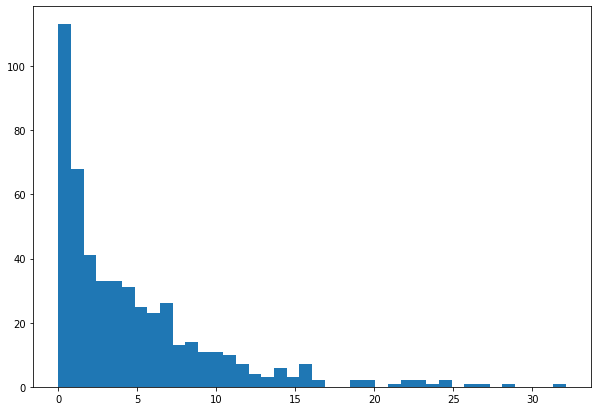

In [ ]:
fig, ax = plt.subplots(figsize =(10, 7))
ret = pd.qcut(data_points, 10)
print(ret)
ax.hist(data_points, bins=40)
plt.show()

In [ ]:
np.random.seed(52)
sample_size = 1000
new_seeds = np.random.randint(10000000, size=2000)
data_points2 = []
p_vals = []

start_time = time.time()
for count, seed in enumerate(new_seeds):
    loop_start_time = time.time()

    np.random.seed(seed)
    ## ********* Below looks Chi-Squared *********
    # samp2 = generate_sample(1000, covariates=250)
    samp2 = generate_sample(5000, covariates=2)
    
    log_reg1 = sm.Logit(samp2.y.to_list(), samp2.loc[:,~samp2.columns.isin(['y', 1])]).fit(disp=0)
    log_reg2 = sm.Logit(samp2.y.to_list(), samp2.loc[:,~samp2.columns.isin(['y'])]).fit(disp=0)

    lrt = -2 * (log_reg1.llf - log_reg2.llf)
    data_points2.append(lrt)
    p_vals.append(scipy.stats.chi2.sf(lrt, 1))

    if count % 10 == 0:
        end_time = time.time()
        print(f'Count: {count} Since Start: {end_time - start_time} Current Loop: {end_time - loop_start_time}')


Count: 0 Since Start: 0.09796333312988281 Current Loop: 0.09717607498168945
Count: 10 Since Start: 0.8925981521606445 Current Loop: 0.07053661346435547
Count: 20 Since Start: 1.6477093696594238 Current Loop: 0.0720663070678711
Count: 30 Since Start: 2.3737592697143555 Current Loop: 0.06667518615722656
Count: 40 Since Start: 3.0949108600616455 Current Loop: 0.07454538345336914
Count: 50 Since Start: 3.8001515865325928 Current Loop: 0.06635069847106934
Count: 60 Since Start: 4.502015113830566 Current Loop: 0.06965851783752441
Count: 70 Since Start: 5.196509122848511 Current Loop: 0.06682968139648438
Count: 80 Since Start: 5.939950466156006 Current Loop: 0.07565951347351074
Count: 90 Since Start: 6.639087438583374 Current Loop: 0.06356048583984375
Count: 100 Since Start: 7.353656768798828 Current Loop: 0.09379220008850098
Count: 110 Since Start: 8.099276065826416 Current Loop: 0.08105969429016113
Count: 120 Since Start: 8.843137979507446 Current Loop: 0.06920385360717773
Count: 130 Since 

RET:  [(2374.325, 2943.35], (2263.16, 2374.325], (1848.486, 1937.178], (2127.208, 2192.401], (1937.178, 2007.132], (2007.132, 2070.714], (2070.714, 2127.208], (2192.401, 2263.16], (1059.294, 1735.986], (1735.986, 1848.486]]
Categories (10, interval[float64, right]): [(1059.294, 1735.986] < (1735.986, 1848.486] <
                                            (1848.486, 1937.178] < (1937.178, 2007.132] < ... <
                                            (2127.208, 2192.401] < (2192.401, 2263.16] <
                                            (2263.16, 2374.325] < (2374.325, 2943.35]]
2374.325 2943.35
2263.16 2374.325
1848.486 1937.178
2127.208 2192.401
1937.178 2007.132
2007.132 2070.714
2070.714 2127.208
2192.401 2263.16
1059.294 1735.986
1735.986 1848.486
END END END


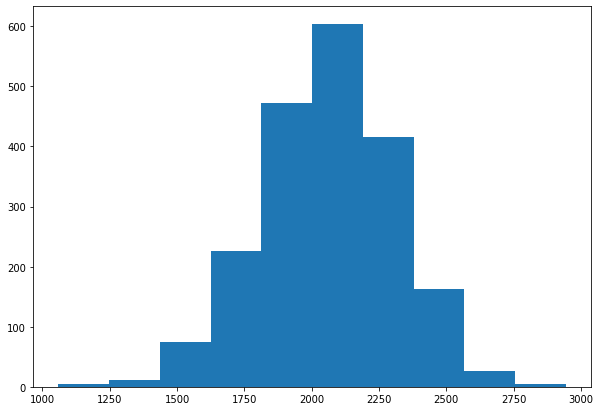

In [ ]:
fig, ax = plt.subplots(figsize =(10, 7))
ret = pd.qcut(data_points2, 10)
print('RET: ', ret.as_ordered().unique())
for item in ret.unique():
  print(item.left, item.right)
print('END END END' )
ax.hist(data_points2)
plt.show()